# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████████████████████████████████████████████████████| 60.0K/60.0K [01:38<00:00, 607File/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

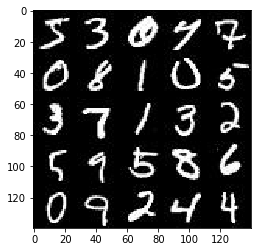

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

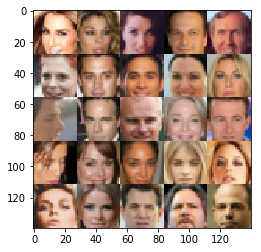

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    placeholder_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    placeholder_z_data = tf.placeholder(tf.float32, (None, z_dim))
    placeholder_learning_rate = tf.placeholder(tf.float32)

    return placeholder_images, placeholder_z_data, placeholder_learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [106]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):        
        # Input layer is 28x28x3
                
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        # 14x14x128
        
        x11 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x11 = tf.layers.batch_normalization(x11, training=True)
        x11 = tf.maximum(alpha * x11, x11)
        # 7x7x256        
        
        x2 = tf.layers.conv2d(x11, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256
        
        x3 = tf.layers.conv2d(x2, 512, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        # 4x4x512
        
        # Flatten it
        flat = tf.contrib.layers.flatten(x3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [107]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """    
    alpha = 0.2
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 2x2x512 now

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [92]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [93]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [94]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])
                    
    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [109]:
train_show_every = 100
train_print_every = 10

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
            
    steps = 0
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)        
    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
            
    with tf.Session() as sess:        
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Rescale to [-1; 1] for tanh.
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})                
                
                if steps % train_print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
    
                if steps % train_show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)               

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Discriminator Loss: 1.0272... Generator Loss: 10.0401
Discriminator Loss: 0.8724... Generator Loss: 14.2267
Discriminator Loss: 0.1557... Generator Loss: 2.2880
Discriminator Loss: 0.0200... Generator Loss: 4.6751
Discriminator Loss: 0.2011... Generator Loss: 1.9520
Discriminator Loss: 0.0018... Generator Loss: 9.8331
Discriminator Loss: 0.0316... Generator Loss: 4.4347
Discriminator Loss: 1.9258... Generator Loss: 0.2279
Discriminator Loss: 0.7054... Generator Loss: 0.7948
Discriminator Loss: 0.1605... Generator Loss: 7.9977


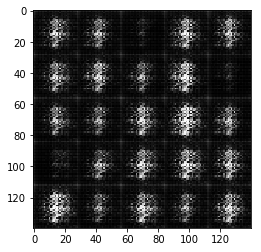

Discriminator Loss: 1.2205... Generator Loss: 6.0601
Discriminator Loss: 0.1204... Generator Loss: 3.1532
Discriminator Loss: 0.3569... Generator Loss: 1.9292
Discriminator Loss: 0.1379... Generator Loss: 3.6708
Discriminator Loss: 0.1361... Generator Loss: 3.2020
Discriminator Loss: 0.0736... Generator Loss: 3.3399
Discriminator Loss: 0.0585... Generator Loss: 4.7163
Discriminator Loss: 0.0054... Generator Loss: 10.3818
Discriminator Loss: 0.4700... Generator Loss: 1.3423
Discriminator Loss: 0.2236... Generator Loss: 2.3440


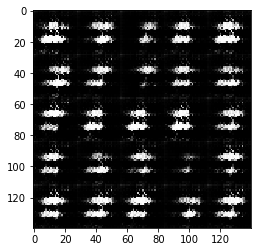

Discriminator Loss: 0.2969... Generator Loss: 1.6279
Discriminator Loss: 0.1016... Generator Loss: 3.1160
Discriminator Loss: 0.1709... Generator Loss: 2.9019
Discriminator Loss: 0.8410... Generator Loss: 2.3905
Discriminator Loss: 0.1958... Generator Loss: 3.2103
Discriminator Loss: 0.3237... Generator Loss: 3.1342
Discriminator Loss: 0.2351... Generator Loss: 5.3292
Discriminator Loss: 0.3020... Generator Loss: 8.3805
Discriminator Loss: 0.3581... Generator Loss: 1.8825
Discriminator Loss: 0.0537... Generator Loss: 4.8898


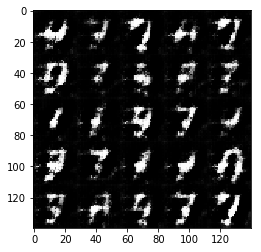

Discriminator Loss: 0.2708... Generator Loss: 2.6965
Discriminator Loss: 0.4200... Generator Loss: 2.5594
Discriminator Loss: 0.5497... Generator Loss: 1.3608
Discriminator Loss: 0.7928... Generator Loss: 0.8754
Discriminator Loss: 0.2586... Generator Loss: 2.6053
Discriminator Loss: 0.5436... Generator Loss: 5.4975
Discriminator Loss: 0.2016... Generator Loss: 2.9077
Discriminator Loss: 0.2589... Generator Loss: 2.6204
Discriminator Loss: 2.4514... Generator Loss: 8.8208
Discriminator Loss: 0.2789... Generator Loss: 6.2929


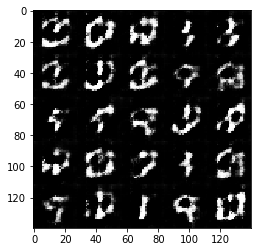

Discriminator Loss: 0.4883... Generator Loss: 1.9390
Discriminator Loss: 0.5590... Generator Loss: 1.5564
Discriminator Loss: 0.0818... Generator Loss: 4.3825
Discriminator Loss: 0.3230... Generator Loss: 3.2880
Discriminator Loss: 0.4304... Generator Loss: 4.1606
Discriminator Loss: 0.4703... Generator Loss: 2.1241
Discriminator Loss: 0.4217... Generator Loss: 1.7579
Discriminator Loss: 0.3079... Generator Loss: 2.3533
Discriminator Loss: 0.3710... Generator Loss: 2.4095
Discriminator Loss: 0.2976... Generator Loss: 2.1594


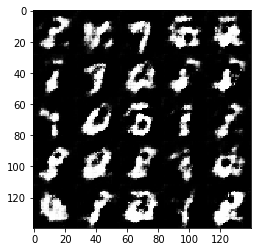

Discriminator Loss: 0.2559... Generator Loss: 2.7314
Discriminator Loss: 0.4449... Generator Loss: 1.4441
Discriminator Loss: 0.3084... Generator Loss: 3.0547
Discriminator Loss: 0.3700... Generator Loss: 3.6801
Discriminator Loss: 0.4514... Generator Loss: 3.6369
Discriminator Loss: 0.3136... Generator Loss: 1.9535
Discriminator Loss: 0.3929... Generator Loss: 1.6562
Discriminator Loss: 0.8903... Generator Loss: 0.8930
Discriminator Loss: 0.7059... Generator Loss: 2.4943
Discriminator Loss: 0.4152... Generator Loss: 2.4752


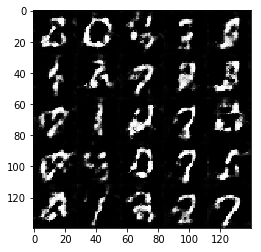

Discriminator Loss: 0.4666... Generator Loss: 2.0299
Discriminator Loss: 0.3266... Generator Loss: 2.7498
Discriminator Loss: 0.3911... Generator Loss: 2.1412
Discriminator Loss: 0.4323... Generator Loss: 1.9662
Discriminator Loss: 0.6977... Generator Loss: 3.0960
Discriminator Loss: 0.4915... Generator Loss: 1.7767
Discriminator Loss: 0.4925... Generator Loss: 2.3604
Discriminator Loss: 0.6421... Generator Loss: 1.1920
Discriminator Loss: 0.4626... Generator Loss: 3.1228
Discriminator Loss: 0.5721... Generator Loss: 3.0304


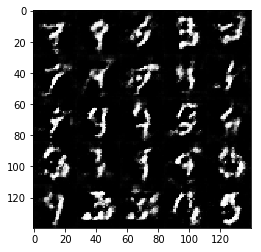

Discriminator Loss: 0.9241... Generator Loss: 0.7964
Discriminator Loss: 0.6380... Generator Loss: 3.3561
Discriminator Loss: 0.5238... Generator Loss: 1.7590
Discriminator Loss: 0.6975... Generator Loss: 1.1346
Discriminator Loss: 0.4481... Generator Loss: 1.6285
Discriminator Loss: 0.5738... Generator Loss: 1.3130
Discriminator Loss: 0.4519... Generator Loss: 2.3696
Discriminator Loss: 0.3409... Generator Loss: 3.1935
Discriminator Loss: 0.6653... Generator Loss: 1.2556
Discriminator Loss: 0.4727... Generator Loss: 1.7090


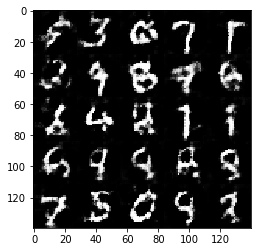

Discriminator Loss: 0.4698... Generator Loss: 3.9647
Discriminator Loss: 0.4472... Generator Loss: 2.0662
Discriminator Loss: 0.5063... Generator Loss: 1.4400
Discriminator Loss: 0.5222... Generator Loss: 1.7391
Discriminator Loss: 1.0913... Generator Loss: 0.6012
Discriminator Loss: 0.9340... Generator Loss: 3.8201
Discriminator Loss: 0.6247... Generator Loss: 1.1870
Discriminator Loss: 0.7979... Generator Loss: 0.8739
Discriminator Loss: 0.6775... Generator Loss: 3.6998
Discriminator Loss: 0.4697... Generator Loss: 1.4202


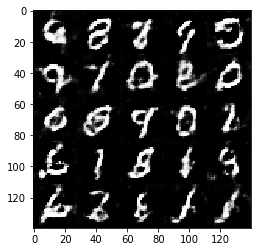

Discriminator Loss: 0.5272... Generator Loss: 1.4365
Discriminator Loss: 0.4321... Generator Loss: 2.6370
Discriminator Loss: 0.3921... Generator Loss: 2.0283


In [110]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Discriminator Loss: 0.1026... Generator Loss: 10.2006
Discriminator Loss: 0.0437... Generator Loss: 10.4192
Discriminator Loss: 0.1347... Generator Loss: 4.1241
Discriminator Loss: 0.0762... Generator Loss: 9.3088
Discriminator Loss: 1.4594... Generator Loss: 0.3003
Discriminator Loss: 0.8745... Generator Loss: 4.8210
Discriminator Loss: 0.6400... Generator Loss: 1.0007
Discriminator Loss: 0.3904... Generator Loss: 2.4415
Discriminator Loss: 1.0219... Generator Loss: 3.3030
Discriminator Loss: 0.3226... Generator Loss: 4.5252


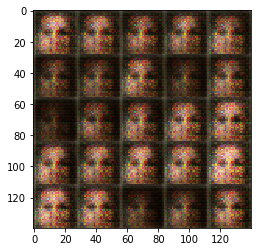

Discriminator Loss: 0.2219... Generator Loss: 2.5495
Discriminator Loss: 0.2341... Generator Loss: 3.9928
Discriminator Loss: 0.6068... Generator Loss: 1.8154
Discriminator Loss: 0.2262... Generator Loss: 2.6497
Discriminator Loss: 0.4024... Generator Loss: 1.7377
Discriminator Loss: 0.4897... Generator Loss: 1.5162
Discriminator Loss: 0.3752... Generator Loss: 1.9887
Discriminator Loss: 0.6981... Generator Loss: 1.1059
Discriminator Loss: 0.3842... Generator Loss: 2.4308
Discriminator Loss: 0.6572... Generator Loss: 1.2336


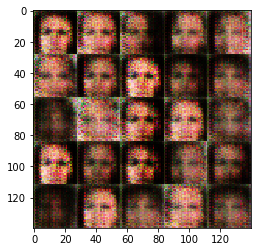

Discriminator Loss: 0.9409... Generator Loss: 0.7511
Discriminator Loss: 0.5704... Generator Loss: 1.0555
Discriminator Loss: 0.7557... Generator Loss: 0.8200
Discriminator Loss: 0.6448... Generator Loss: 1.2275
Discriminator Loss: 0.8150... Generator Loss: 2.7976
Discriminator Loss: 0.6067... Generator Loss: 2.7781
Discriminator Loss: 1.7703... Generator Loss: 0.2563
Discriminator Loss: 0.9070... Generator Loss: 2.6232
Discriminator Loss: 1.2484... Generator Loss: 1.2935
Discriminator Loss: 1.1564... Generator Loss: 0.7813


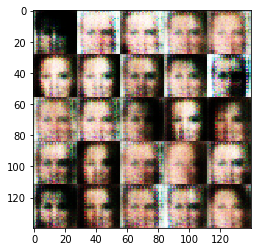

Discriminator Loss: 0.8470... Generator Loss: 1.2400
Discriminator Loss: 0.5448... Generator Loss: 1.3511
Discriminator Loss: 1.1033... Generator Loss: 0.5783
Discriminator Loss: 0.7257... Generator Loss: 1.2635
Discriminator Loss: 0.8270... Generator Loss: 2.2608
Discriminator Loss: 0.8843... Generator Loss: 0.9658
Discriminator Loss: 0.7220... Generator Loss: 1.2493
Discriminator Loss: 0.7900... Generator Loss: 1.1337
Discriminator Loss: 1.2585... Generator Loss: 4.7444
Discriminator Loss: 0.7567... Generator Loss: 2.2333


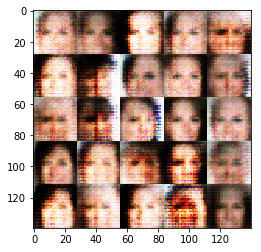

Discriminator Loss: 0.8946... Generator Loss: 0.9799
Discriminator Loss: 0.7982... Generator Loss: 0.8706
Discriminator Loss: 0.5276... Generator Loss: 1.6980
Discriminator Loss: 0.7923... Generator Loss: 1.5517
Discriminator Loss: 0.8139... Generator Loss: 0.9444
Discriminator Loss: 0.6099... Generator Loss: 1.1075
Discriminator Loss: 0.7060... Generator Loss: 1.8791
Discriminator Loss: 0.8041... Generator Loss: 1.0589
Discriminator Loss: 0.8018... Generator Loss: 1.0217
Discriminator Loss: 0.5175... Generator Loss: 1.5231


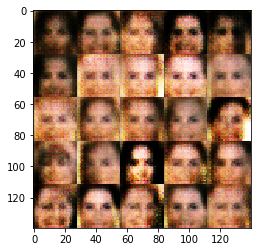

Discriminator Loss: 0.5582... Generator Loss: 1.9508
Discriminator Loss: 0.8873... Generator Loss: 1.1430
Discriminator Loss: 2.2603... Generator Loss: 0.1537
Discriminator Loss: 1.1099... Generator Loss: 0.7427
Discriminator Loss: 1.2605... Generator Loss: 2.2431
Discriminator Loss: 1.1379... Generator Loss: 0.5802
Discriminator Loss: 1.1150... Generator Loss: 0.9672
Discriminator Loss: 1.2595... Generator Loss: 0.5784
Discriminator Loss: 0.9709... Generator Loss: 0.8656
Discriminator Loss: 0.7688... Generator Loss: 1.5677


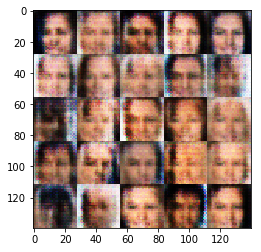

Discriminator Loss: 0.8604... Generator Loss: 0.9307
Discriminator Loss: 0.8519... Generator Loss: 1.5841
Discriminator Loss: 1.2583... Generator Loss: 0.5288
Discriminator Loss: 1.3057... Generator Loss: 2.3620
Discriminator Loss: 0.7998... Generator Loss: 1.0121
Discriminator Loss: 0.6518... Generator Loss: 1.4149
Discriminator Loss: 1.1075... Generator Loss: 3.2668
Discriminator Loss: 0.6492... Generator Loss: 1.1727
Discriminator Loss: 0.5326... Generator Loss: 1.9573
Discriminator Loss: 0.8425... Generator Loss: 1.4244


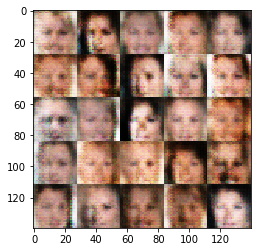

Discriminator Loss: 1.0486... Generator Loss: 0.6931
Discriminator Loss: 0.7842... Generator Loss: 0.9365
Discriminator Loss: 0.8540... Generator Loss: 0.9148
Discriminator Loss: 0.7626... Generator Loss: 1.2874
Discriminator Loss: 0.8490... Generator Loss: 1.2062
Discriminator Loss: 0.7223... Generator Loss: 1.9441
Discriminator Loss: 0.8624... Generator Loss: 0.9865
Discriminator Loss: 1.6634... Generator Loss: 0.2930
Discriminator Loss: 0.8246... Generator Loss: 1.4389
Discriminator Loss: 1.0041... Generator Loss: 0.7826


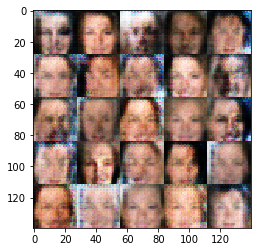

Discriminator Loss: 0.7829... Generator Loss: 0.9631
Discriminator Loss: 0.8433... Generator Loss: 0.8273
Discriminator Loss: 0.9304... Generator Loss: 1.4588
Discriminator Loss: 0.8729... Generator Loss: 1.0040
Discriminator Loss: 1.1544... Generator Loss: 1.8233
Discriminator Loss: 1.2418... Generator Loss: 0.5417
Discriminator Loss: 0.9750... Generator Loss: 0.8142
Discriminator Loss: 0.8549... Generator Loss: 0.9553
Discriminator Loss: 0.7789... Generator Loss: 0.8918
Discriminator Loss: 0.7268... Generator Loss: 1.2168


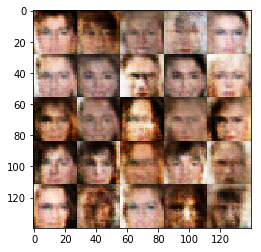

Discriminator Loss: 0.6813... Generator Loss: 2.3031
Discriminator Loss: 0.7268... Generator Loss: 1.2427
Discriminator Loss: 0.6057... Generator Loss: 1.6762
Discriminator Loss: 0.9574... Generator Loss: 0.7550
Discriminator Loss: 0.7944... Generator Loss: 2.0618
Discriminator Loss: 0.8921... Generator Loss: 0.8665
Discriminator Loss: 0.8711... Generator Loss: 0.9037
Discriminator Loss: 0.7373... Generator Loss: 1.4938
Discriminator Loss: 0.6478... Generator Loss: 1.5122
Discriminator Loss: 1.0291... Generator Loss: 0.6316


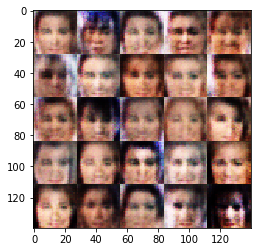

Discriminator Loss: 0.9131... Generator Loss: 1.0660
Discriminator Loss: 0.7931... Generator Loss: 0.9982
Discriminator Loss: 0.8003... Generator Loss: 2.3716
Discriminator Loss: 0.9871... Generator Loss: 0.8257
Discriminator Loss: 0.7233... Generator Loss: 1.5328
Discriminator Loss: 0.7343... Generator Loss: 1.0553
Discriminator Loss: 0.8423... Generator Loss: 1.6324
Discriminator Loss: 0.6413... Generator Loss: 2.3646
Discriminator Loss: 0.7577... Generator Loss: 0.9350
Discriminator Loss: 0.7540... Generator Loss: 1.5156


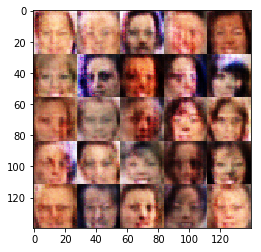

Discriminator Loss: 0.6906... Generator Loss: 1.5577
Discriminator Loss: 0.7345... Generator Loss: 1.8375
Discriminator Loss: 0.7057... Generator Loss: 1.4492
Discriminator Loss: 0.6790... Generator Loss: 1.1246
Discriminator Loss: 0.7260... Generator Loss: 1.0792
Discriminator Loss: 0.6902... Generator Loss: 1.1800
Discriminator Loss: 0.8417... Generator Loss: 1.0082
Discriminator Loss: 0.6653... Generator Loss: 1.5147
Discriminator Loss: 0.8416... Generator Loss: 2.1395
Discriminator Loss: 0.6440... Generator Loss: 2.1262


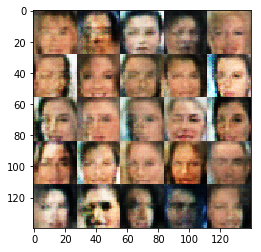

Discriminator Loss: 0.7480... Generator Loss: 1.1439
Discriminator Loss: 0.6657... Generator Loss: 1.6858
Discriminator Loss: 0.6550... Generator Loss: 1.2049
Discriminator Loss: 0.5999... Generator Loss: 1.5491
Discriminator Loss: 0.6751... Generator Loss: 1.7588
Discriminator Loss: 0.8746... Generator Loss: 0.8586
Discriminator Loss: 0.6292... Generator Loss: 1.1940
Discriminator Loss: 0.6430... Generator Loss: 1.4071
Discriminator Loss: 0.8746... Generator Loss: 2.1934
Discriminator Loss: 0.9259... Generator Loss: 0.7829


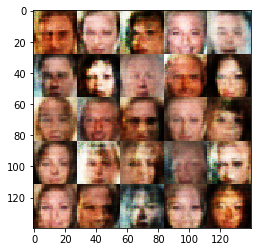

Discriminator Loss: 0.8296... Generator Loss: 0.9049
Discriminator Loss: 0.8030... Generator Loss: 1.7341
Discriminator Loss: 0.5056... Generator Loss: 1.5932
Discriminator Loss: 0.8233... Generator Loss: 0.9857
Discriminator Loss: 0.7085... Generator Loss: 0.9838
Discriminator Loss: 0.7625... Generator Loss: 1.4861
Discriminator Loss: 0.6416... Generator Loss: 2.1102
Discriminator Loss: 0.7891... Generator Loss: 2.0716
Discriminator Loss: 0.6463... Generator Loss: 1.1730
Discriminator Loss: 0.8985... Generator Loss: 0.7009


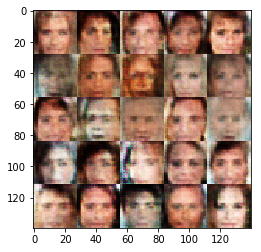

Discriminator Loss: 0.6657... Generator Loss: 1.2230
Discriminator Loss: 1.3903... Generator Loss: 0.4023
Discriminator Loss: 0.7587... Generator Loss: 1.7087
Discriminator Loss: 0.7821... Generator Loss: 1.5527
Discriminator Loss: 0.9194... Generator Loss: 3.1345
Discriminator Loss: 0.7209... Generator Loss: 1.1328
Discriminator Loss: 0.8734... Generator Loss: 1.0610
Discriminator Loss: 0.5400... Generator Loss: 2.2499
Discriminator Loss: 0.5454... Generator Loss: 1.4788
Discriminator Loss: 0.6522... Generator Loss: 1.1738


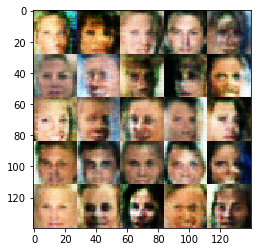

Discriminator Loss: 0.9647... Generator Loss: 1.5193
Discriminator Loss: 0.9580... Generator Loss: 0.7033
Discriminator Loss: 0.9740... Generator Loss: 0.7595
Discriminator Loss: 1.1145... Generator Loss: 0.5756
Discriminator Loss: 0.5915... Generator Loss: 1.8484
Discriminator Loss: 0.6450... Generator Loss: 1.4769
Discriminator Loss: 0.7322... Generator Loss: 1.2148
Discriminator Loss: 0.6382... Generator Loss: 1.1825


In [111]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.